In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn import preprocessing

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('./data/Urban_Forestry_Street_Trees.csv')

/usr/local/var/pyenv/versions/3.6.2/envs/njcodenight/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.columns

Index(['X', 'Y', 'OBJECTID', 'FACILITYID', 'VICINITY', 'WARD', 'TBOX_L',
       'TBOX_W', 'WIRES', 'CURB', 'SIDEWALK', 'TBOX_STAT', 'RETIREDDT',
       'SCI_NM', 'CMMN_NM', 'DATE_PLANT', 'DBH', 'DISEASE', 'PESTS',
       'CONDITION', 'CONDITIODT', 'OWNERSHIP', 'TREE_NOTES', 'ONEYEARPHOTO',
       'SPECIALPHOTO', 'PHOTOREMARKS', 'ELEVATION', 'SIGN', 'TRRS', 'WARRANTY',
       'FAM_NAME', 'CREATED_USER', 'CREATED_DATE', 'EDITEDBY',
       'LAST_EDITED_USER', 'LAST_EDITED_DATE', 'GENUS_NAME'],
      dtype='object')

In [5]:
df.dropna(subset = ['GENUS_NAME'], inplace=True) 
df['counter'] = 1

In [7]:
species_count = df.groupby('GENUS_NAME').counter.sum().reset_index()

In [8]:
# look at the top ten 
species_count.sort_values('counter', ascending=False).reset_index(drop=True)[:10]

,GENUS_NAME,counter
0,Quercus,38329
1,Acer,29428
2,Ulmus,14507
3,Prunus,9738
4,Other,7440
5,Platanus,6961
6,Zelkova,5905
7,Tilia,5196
8,Ginkgo,4625
9,Cercis,3977


# What tree families are these?
Quercus - Maple 

Acer - Elm

Ulmus - Oak

Prunus - Plum, Cherry

In [9]:
limited_df = df[ (df.GENUS_NAME=='Prunus') ]


# encode the names because computers do not understand english
genus_names = limited_df.GENUS_NAME.unique()
genus_le = preprocessing.LabelEncoder()
genus_le.fit(genus_names)
limited_df['genus_code'] = genus_le.transform(limited_df.GENUS_NAME) 

/usr/local/var/pyenv/versions/3.6.2/envs/njcodenight/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
limited_df.CMMN_NM.value_counts()

Cherry                2180
Kwanzan cherry        1906
Yoshino cherry        1510
Chokecherry           1487
Cherry (Snowgoose)    1436
Okame cherry           519
Purple leaf plum       404
Japanese Apricot        32
Lilac                    2
Yellowwood               2
Chinese pistachio        2
Crape myrtle             1
Red maple                1
Name: CMMN_NM, dtype: int64

In [9]:
featured = ['X', 'Y']

In [10]:
features = limited_df[featured].as_matrix()
y = limited_df.genus_code.values


In [37]:
import mplleaflet

# sample = limited_df.sample(1000)
# plt.scatter(sample['X'], sample['Y'], c=sample['genus_code'])

# mplleaflet.display()


In [16]:
import geopandas as gpd

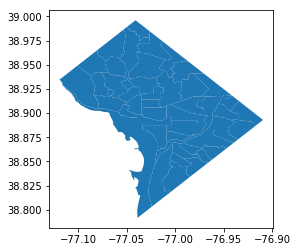

In [31]:
# http://opendata.dc.gov/datasets/neighborhood-clusters/data

dc = gpd.read_file("./data/Neighborhood_Clusters/Neighborhood_Clusters.shp")
dc.plot()

In [27]:
import shapely

In [29]:
tree_locations = gpd.GeoDataFrame(limited_df, geometry=limited_df.apply(
        lambda srs: shapely.geometry.Point(srs['X'], srs['Y']), axis='columns'
    ))

/usr/local/var/pyenv/versions/3.6.2/envs/njcodenight/lib/python3.6/site-packages/seaborn/distributions.py:645: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


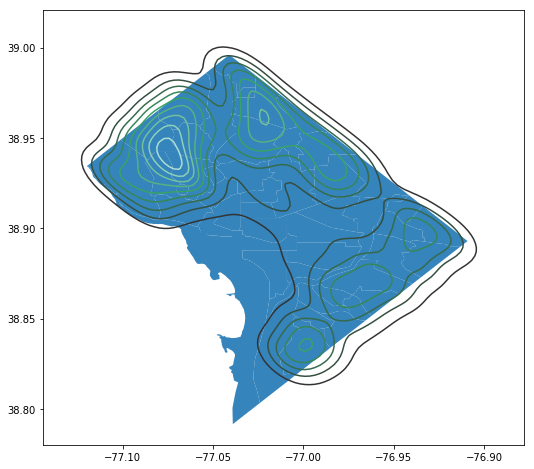

In [36]:
import seaborn as sns

# f = plt.figure(figsize=(15, 8))
ax = dc.plot(figsize=(15, 8))
# ax = f.gca()
dc.plot(ax=ax, alpha=0.1, linewidth=0.25, color='white')
sns.kdeplot(data=tree_locations.apply(lambda srs: pd.Series({'x': srs.geometry.x, 'y': srs.geometry.y}), axis='columns'), ax=ax,
            alpha=1)
# ax.set_axis_off()

In [43]:
# lets assign a neighborhood to each tree

import numpy as np

def assign_neighborhood_tract(tree):
    bools = [geom.contains(tree['geometry']) for geom in dc['geometry']]
    if True in bools:
        return dc.iloc[bools.index(True)]['NAME']
    else:
        return np.nan

In [44]:
tree_locations['neighborhood'] = tree_locations.apply(assign_neighborhood_tract, axis='columns')


In [53]:
tree_locations['trees'] = tree_locations['neighborhood'].map(tree_locations['neighborhood'].value_counts())

In [54]:
tree_locations

,X,Y,OBJECTID,FACILITYID,VICINITY,WARD,TBOX_L,TBOX_W,WIRES,CURB,...,CREATED_DATE,EDITEDBY,LAST_EDITED_USER,LAST_EDITED_DATE,GENUS_NAME,counter,genus_code,geometry,neighborhood,trees
39,-77.092344,38.944844,18046575,19119-460-3005-0492-000,4639 WARREN ST NW,3.0,99.0,6.0,Both,Permanent,...,NaN,mchuko,ufaarborist,2017-04-21T17:38:08.000Z,Prunus,1,0,POINT (-77.09234387949999 38.9448438405),Cluster 11,728.0
52,-77.010197,38.874692,18046588,46318-003-3005-0050-000,OPP 20 N ST SW,6.0,99.0,7.0,Low Voltage,Permanent,...,NaN,sward,ufaarborist,2017-03-02T16:55:24.000Z,Prunus,1,0,POINT (-77.01019724449999 38.8746918603),Cluster 9,48.0
73,-77.026447,38.919138,18046609,19015-100-3001-0129-000,1010 W ST NW,1.0,9.0,4.0,None,Permanent,...,NaN,jmiller,ufaarborist,2017-09-19T16:19:51.000Z,Prunus,1,0,POINT (-77.0264473852 38.9191378912),Cluster 3,61.0
145,-76.959733,38.885871,18046681,NaN,300 BLK 33RD ST SE,7.0,99.0,4.0,Low Voltage,Permanent,...,2016-08-02T17:04:33.000Z,jburckle,ufaarborist,2016-08-02T17:32:58.000Z,Prunus,1,0,POINT (-76.95973276879998 38.8858705243),Cluster 32,223.0
146,-76.959731,38.885793,18046682,NaN,300 BLK 33RD ST SE,7.0,99.0,4.0,Low Voltage,Permanent,...,2016-08-02T17:17:10.000Z,jburckle,ufaarborist,2016-08-02T17:33:18.000Z,Prunus,1,0,POINT (-76.9597305713 38.8857925636),Cluster 32,223.0
148,-76.959735,38.885654,18046684,NaN,300 BLK 33RD ST SE,7.0,99.0,4.0,Low Voltage,Permanent,...,2016-08-02T17:19:00.000Z,jburckle,ufaarborist,2016-08-02T17:33:44.000Z,Prunus,1,0,POINT (-76.9597350113 38.8856540959),Cluster 32,223.0
224,-77.075555,38.922505,18046760,12002-380-3001-0236-000,3824 CALVERT ST NW,3.0,99.0,5.0,Both,Permanent,...,NaN,mertem,mertem,2016-05-16T13:59:56.000Z,Prunus,1,0,POINT (-77.0755552615 38.9225051607),Cluster 14,274.0
250,-76.976310,38.848070,18046786,37839-190-3001-0656-000,1920 SAVANNAH TER SE,8.0,99.0,4.0,Both,Permanent,...,NaN,joneill,joneill,2017-09-07T14:08:23.000Z,Prunus,1,0,POINT (-76.97630963839998 38.8480698325),Cluster 38,133.0
352,-76.972898,38.847131,18046888,30220-340-3005-0097-000,3401 22ND ST SE,8.0,99.0,6.0,Both,Permanent,...,NaN,joneill,joneill,2015-07-07T12:54:39.000Z,Prunus,1,0,POINT (-76.9728984764 38.8471309382),Cluster 38,133.0
424,-76.959634,38.865828,18046960,31735-195-3001-0249-000,1900 BLK BRANCH AVE SE,7.0,99.0,3.0,Both,Permanent,...,NaN,kyturralde,kyturralde,2016-08-02T16:39:18.000Z,Prunus,1,0,POINT (-76.9596341022 38.8658279759),Cluster 34,534.0
